In [3]:
## Enviroment Setup
import os, sys
WORKING_DIR = '/home/peizhi/Documents/flame-head-tracker'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())

## Computing Device
device = 'cuda:0'
import torch
torch.cuda.set_device(device) # this will solve the problem that OpenGL not on the same device with torch tensors

import matplotlib.pyplot as plt
import numpy as np

from tracker_base import Tracker

def plot(ret_dict):
    # plot some results
    plt.figure(figsize=(15,6))
    plt.subplot(1,6,1); plt.imshow(ret_dict['img'][0]); plt.title('img'); plt.axis('off')
    plt.subplot(1,6,2); plt.imshow(ret_dict['img_aligned'][0]); plt.title('img_aligned'); plt.axis('off')
    plt.subplot(1,6,3); plt.imshow(ret_dict['parsing'][0]); plt.title('parsing'); plt.axis('off')
    plt.subplot(1,6,4); plt.imshow(ret_dict['parsing_aligned'][0]); plt.title('parsing_aligned'); plt.axis('off')
    plt.subplot(1,6,5); plt.imshow(ret_dict['img_rendered'][0]); plt.title('img_rendered'); plt.axis('off')
    plt.subplot(1,6,6); plt.imshow(ret_dict['mesh_rendered'][0]); plt.title('mesh_rendered'); plt.axis('off')
    plt.show()


###########################
## Setup Flame Tracker    #     
###########################

tracker_cfg = {
    'mediapipe_face_landmarker_v2_path': './models/face_landmarker.task',
    'flame_model_path': './models/FLAME2020/generic_model.pkl',
    'flame_lmk_embedding_path': './models/landmark_embedding.npy',
    'ear_landmarker_path': './models/ear_landmarker.pth', # this is optional, if you do not want to use ear landmarks during fitting, just remove this line
    'tex_space_path': './models/FLAME_albedo_from_BFM.npz',
    'face_parsing_model_path': './models/79999_iter.pth',
    'template_mesh_file_path': './models/head_template.obj',
    'result_img_size': 512,
    'use_matting': True,           # use image/video matting to remove background
    'device': device,
    'use_head_pose': True,         # otherwise the head is fixed and rotation will be soly modeled by camera rotation
}

tracker = Tracker(tracker_cfg)

# optional settings
tracker.update_fov(fov=20)
tracker.set_landmark_detector('mediapipe')


Current Working Directory:  /home/peizhi/Documents/flame-head-tracker


I0000 00:00:1750791568.313131   32644 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1750791568.331660   33282 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.144.03), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1750791568.331967   32644 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1750791568.339161   33285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750791568.356524   33303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Using cache found in /home/peizhi/.cache/torch/hub/PeterL1n_RobustVideoMatting_master


creating the FLAME Decoder


/home/peizhi/Documents/flame-head-tracker/submodules/flame_lib/FLAME.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_faces_idx', torch.tensor(lmk_embeddings['dynamic_lmk_faces_idx'], dtype=torch.long))
/home/peizhi/Documents/flame-head-tracker/submodules/flame_lib/FLAME.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_bary_coords', torch.tensor(lmk_embeddings['dynamic_lmk_bary_coords'], dtype=self.dtype))
/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
/home/p

creating the FLAME Decoder
trained model found. load models/deca_model.tar


/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")



>>> Flame Head Tracker v3.4 ready.


### Demo 1: Landmark-based Fitting



/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


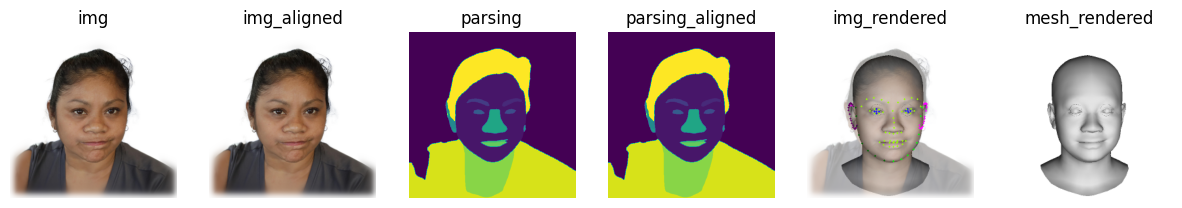

shape (1, 300)
exp (1, 100)
head_pose (1, 3)
jaw_pose (1, 3)
eye_pose (1, 6)
tex (1, 50)
light (1, 9, 3)
cam (1, 6)
img_rendered (1, 256, 256, 3)
mesh_rendered (1, 256, 256, 3)
img (1, 512, 512, 3)
img_aligned (1, 512, 512, 3)
parsing (1, 512, 512)
parsing_aligned (1, 512, 512)
lmks_68 (1, 68, 2)
lmks_ears (1, 20, 2)
lmks_eyes (1, 10, 2)
blendshape_scores (1, 52)


In [4]:
img_path = './assets/FFHQ/00002.png'

# if realign == True, 
# img will be replaced by the realigned image
ret_dict = tracker.load_image_and_run(img_path, realign=True, photometric_fitting=False) 
plot(ret_dict)

# check the shapes of returned results
for key in ret_dict:
    if key == 'fov':
        print('FOV = ', ret_dict[key])
    else:
        print(f'{key} {ret_dict[key].shape}')


### Demo 2: Photometric Fitting

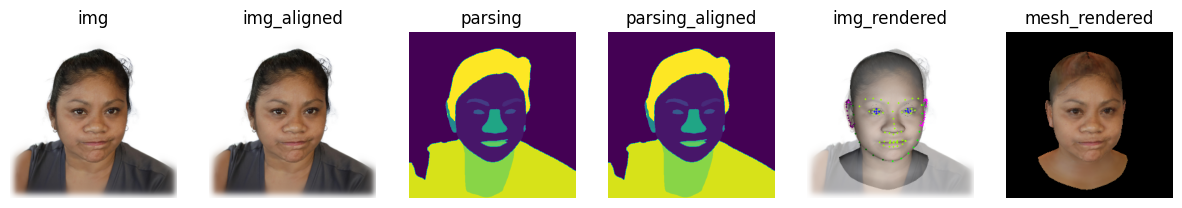

In [5]:
img_path = './assets/FFHQ/00002.png'

ret_dict = tracker.load_image_and_run(img_path, realign=True, photometric_fitting=True) 
plot(ret_dict)


### More Results

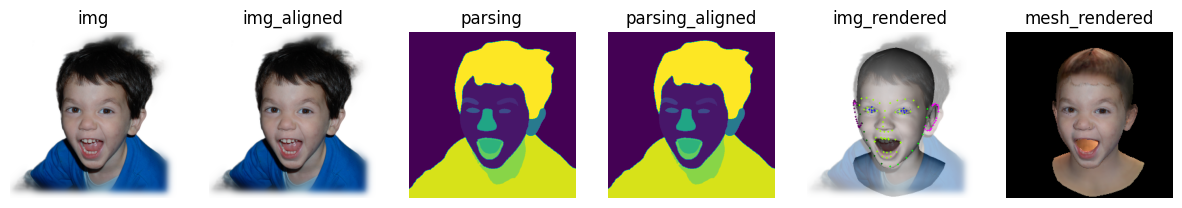

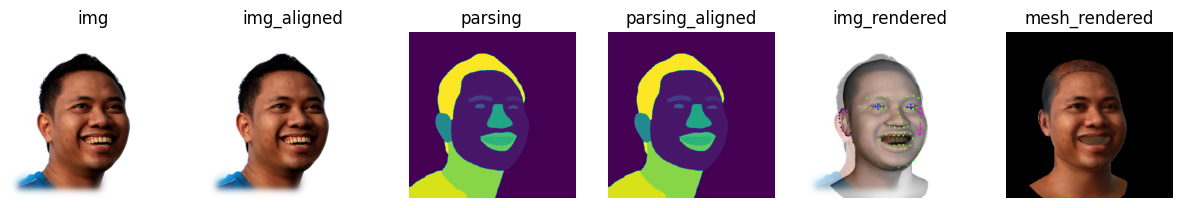

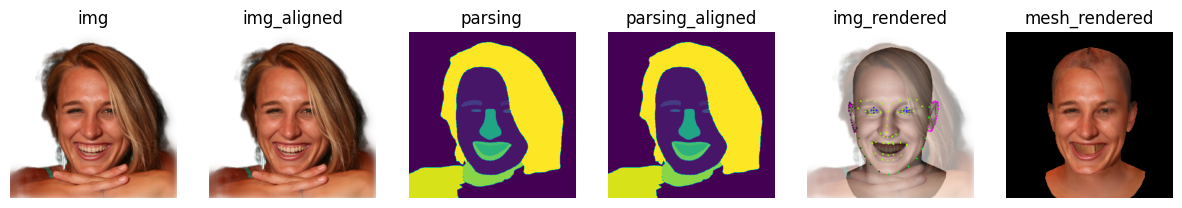

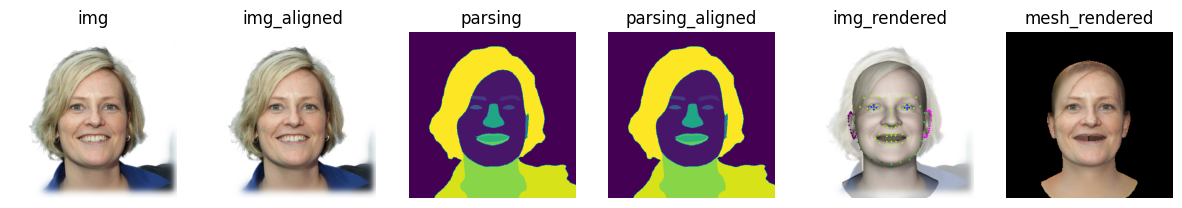

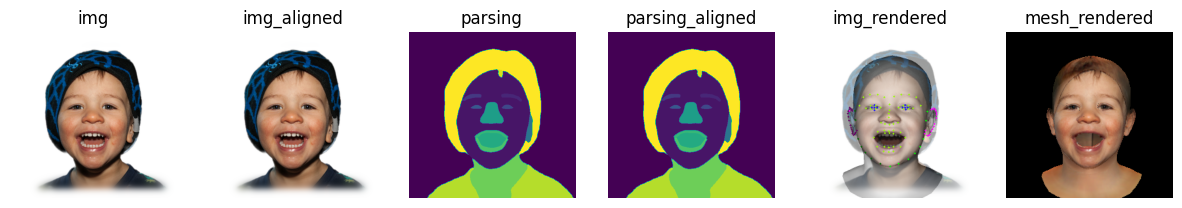

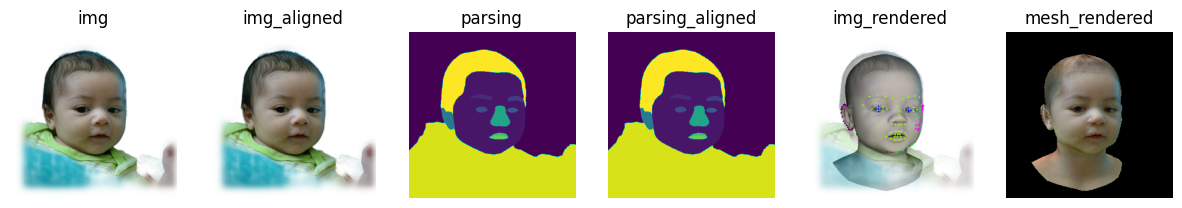

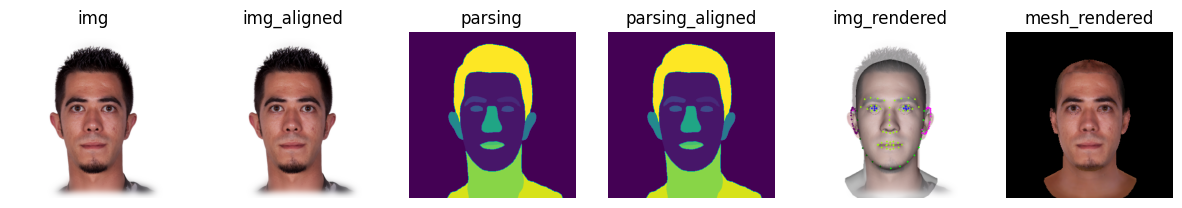

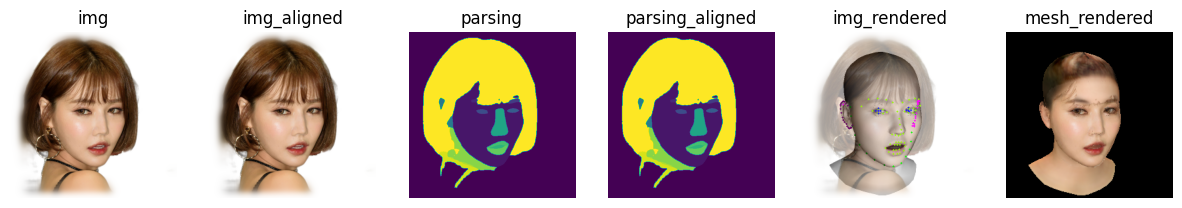

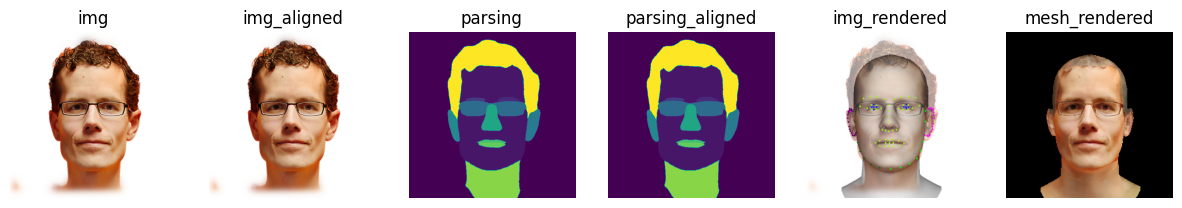

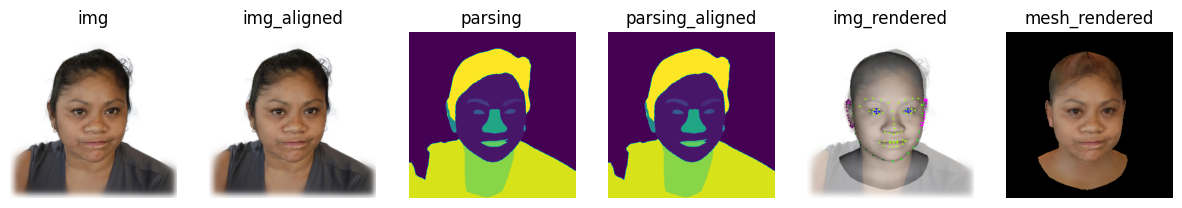

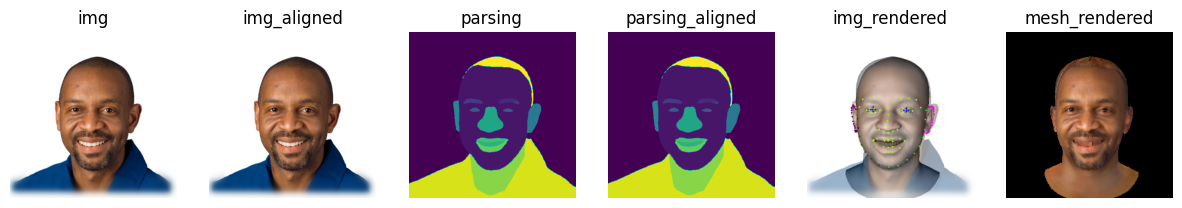

In [6]:
img_paths = [os.path.join('./assets/FFHQ/', f) for f in os.listdir('./assets/FFHQ/') if f.endswith('.png') and f.startswith('.') is False]

for img_path in img_paths:
    ret_dict = tracker.load_image_and_run(img_path, realign=True, photometric_fitting=True) 
    plot(ret_dict)

